<a href="https://colab.research.google.com/github/Deca97/Real_Estate_Price_Prediction/blob/main/Real_Estate_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Un modello di previsione per il mercato immobiliare

# Caricamento librerie

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")


# Caricamento del Dataset

In [ ]:
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv"
df = pd.read_csv(url)
df.info()


df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   bathrooms         545 non-null    int64
 4   stories           545 non-null    int64
 5   mainroad          545 non-null    int64
 6   guestroom         545 non-null    int64
 7   basement          545 non-null    int64
 8   hotwaterheating   545 non-null    int64
 9   airconditioning   545 non-null    int64
 10  parking           545 non-null    int64
 11  prefarea          545 non-null    int64
 12  furnishingstatus  545 non-null    int64
dtypes: int64(13)
memory usage: 55.5 KB


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.858716,0.177982,0.350459,0.045872,0.315596,0.693578,0.234862,1.089908
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.348635,0.382849,0.477552,0.209399,0.465180,0.861586,0.424302,0.858130
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000


In [ ]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1


# Data exploration

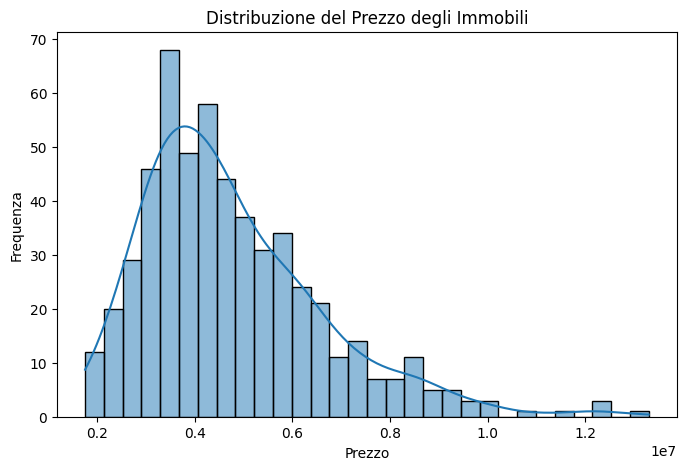

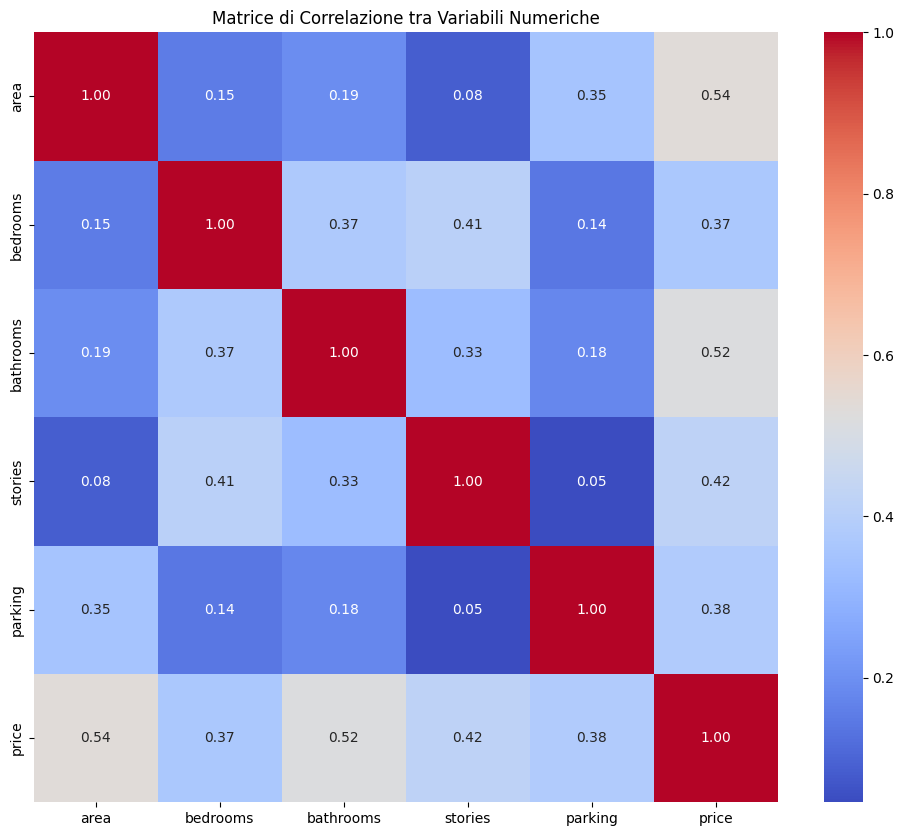

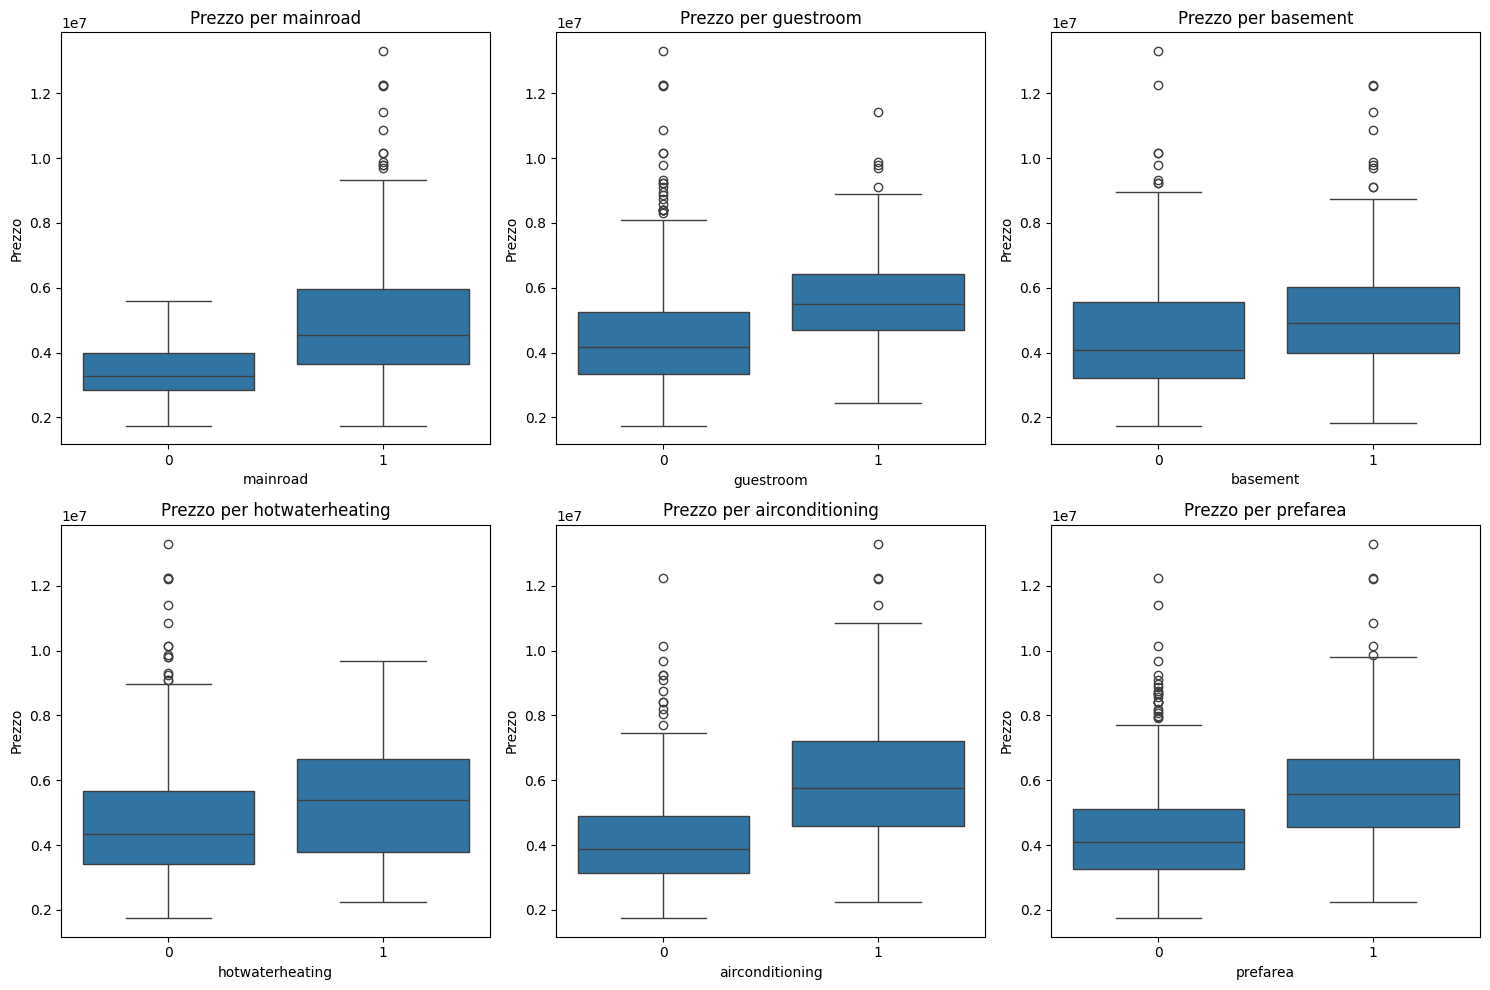

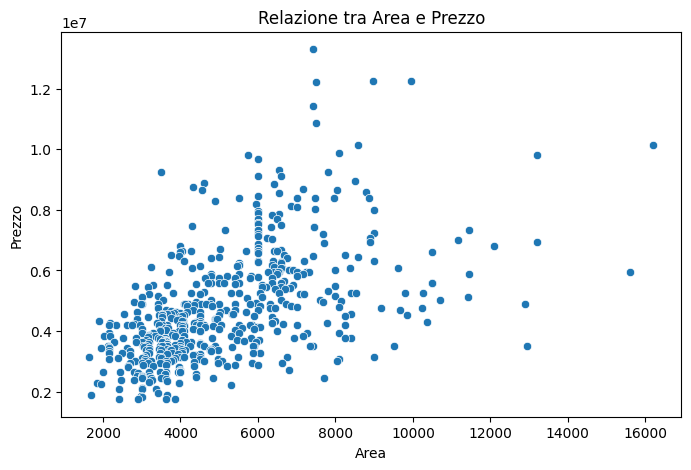

In [ ]:

plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=30, kde=True)
plt.title("Distribuzione del Prezzo degli Immobili")
plt.xlabel("Prezzo")
plt.ylabel("Frequenza")
plt.show()

# Correlazione tra le variabili numeriche
num_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']

plt.figure(figsize=(12, 10))
corr = df[num_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice di Correlazione tra Variabili Numeriche")
plt.show()

binary_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(binary_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=feature, y='price', data=df)
    plt.title(f"Prezzo per {feature}")
    plt.xlabel(feature)
    plt.ylabel("Prezzo")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x='area', y='price', data=df)
plt.title("Relazione tra Area e Prezzo")
plt.xlabel("Area")
plt.ylabel("Prezzo")
plt.show()

* Nessuna correlazione eccessiva (>0.8), quindi il rischio di multicollinearità forte è basso.

* Tutte le variabili binarie hanno un’influenza positiva sul prezzo, ma con intensità diversa (aria condizionata, guestroom e prefarea sembrano più rilevanti).

* Tutte le variabili numeriche hanno un’influenza positiva sul prezzo, ma con intensità diversa (area e numero di bagni sembrano avere più rilevanti).

# Model development

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_validate
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Normalizzazione e feature names
X = df.drop('price', axis=1)
y = df['price']
num_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
X_num = df[num_features]
X_cat = df.drop(columns=num_features + ['price'])

scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=num_features)

X_scaled = pd.concat([X_num_scaled, X_cat.reset_index(drop=True)], axis=1)
feature_names = X_scaled.columns



# GridSearchCV setup
param_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}
param_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
param_elastic = {'alpha': [0.001, 0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.9]}

grid_ridge = GridSearchCV(Ridge(max_iter=10000), param_ridge, scoring='neg_mean_squared_error', cv=5)
grid_lasso = GridSearchCV(Lasso(max_iter=10000), param_lasso, scoring='neg_mean_squared_error', cv=5)
grid_elastic = GridSearchCV(ElasticNet(max_iter=10000), param_elastic, scoring='neg_mean_squared_error', cv=5)

# Fit su tutto il dataset
grid_ridge.fit(X_scaled, y)
grid_lasso.fit(X_scaled, y)
grid_elastic.fit(X_scaled, y)

# Migliori modelli
best_ridge = grid_ridge.best_estimator_
best_lasso = grid_lasso.best_estimator_
best_elastic = grid_elastic.best_estimator_

# Dizionario per i modelli
models = {
    'Ridge': best_ridge,
    'Lasso': best_lasso,
    'ElasticNet': best_elastic
}

# Risultati CV
results = {'Model': [], 'CV_MSE': []}
residuals = {}
coefs = pd.DataFrame({'Feature': feature_names})

for name, model in models.items():
    # Cross-validation MSE
    cv_mse = -cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error').mean()
    results['Model'].append(name)
    results['CV_MSE'].append(cv_mse)

    # Residui da cross_val_predict
    y_pred = cross_val_predict(model, X_scaled, y, cv=5)
    residuals[name] = {'pred': y_pred, 'res': y - y_pred}

    # Coefficienti
    coefs[name] = model.coef_

# Tabella risultati CV
res_df = pd.DataFrame(results)
print("📊 MSE medio su 5 Fold:")
print(res_df)

print("🔍 Migliori iperparametri trovati tramite GridSearchCV:\n")

print(f"Ridge → alpha: {grid_ridge.best_params_['alpha']}")
print(f"Lasso → alpha: {grid_lasso.best_params_['alpha']}")
print(f"ElasticNet → alpha: {grid_elastic.best_params_['alpha']}, l1_ratio: {grid_elastic.best_params_['l1_ratio']}")


# Trova il modello con il miglior MSE CV
best_model_name = res_df.sort_values(by='CV_MSE').iloc[0]['Model']
print(f"✅ Modello con miglior CV MSE: {best_model_name}")

# Seleziona il modello corrispondente già ottimizzato
final_model = models[best_model_name]

# 3. Fitta il modello su tutto il dataset
final_model.fit(X_scaled, y)

# 4. Predizione e R²
y_pred_all = final_model.predict(X_scaled)
r2_all = r2_score(y, y_pred_all)

print(f"📈 R² del modello '{best_model_name}' sull'intero dataset: {r2_all:.4f}")



📊 MSE medio su 5 Fold:
        Model        CV_MSE
0       Ridge  2.156073e+12
1       Lasso  2.156044e+12
2  ElasticNet  2.156172e+12
🔍 Migliori iperparametri trovati tramite GridSearchCV:

Ridge → alpha: 0.01
Lasso → alpha: 0.001
ElasticNet → alpha: 0.001, l1_ratio: 0.9
✅ Modello con miglior CV MSE: Lasso
📈 R² del modello 'Lasso' sull'intero dataset: 0.6791


# 📊  Analisi dei risultati

I tre modelli hanno performance molto simili (MSE ≈ 2.15e+12).
Il Lasso risulta il migliore, anche se di poco, con R² = 0.68, quindi spiega circa il 68% della variabilità del prezzo.
L’uso di α molto piccolo indica che la regolarizzazione ha un impatto limitato.

# Valutazione performance del modello

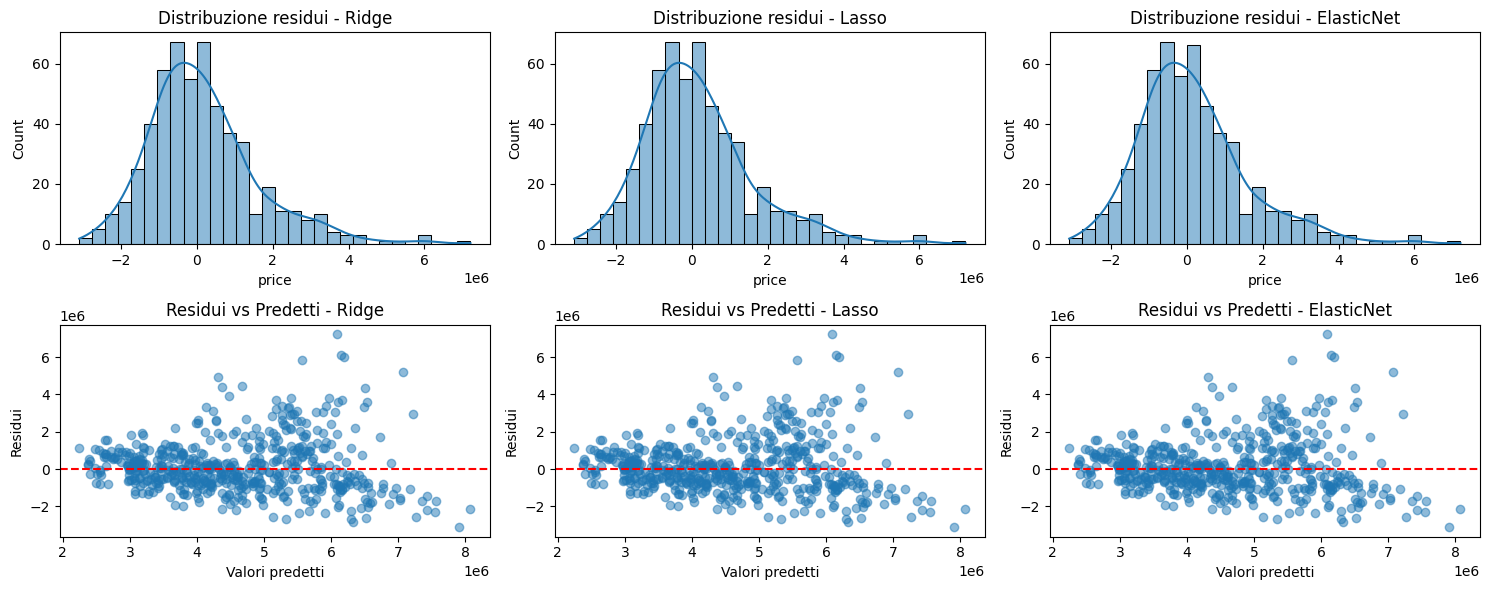

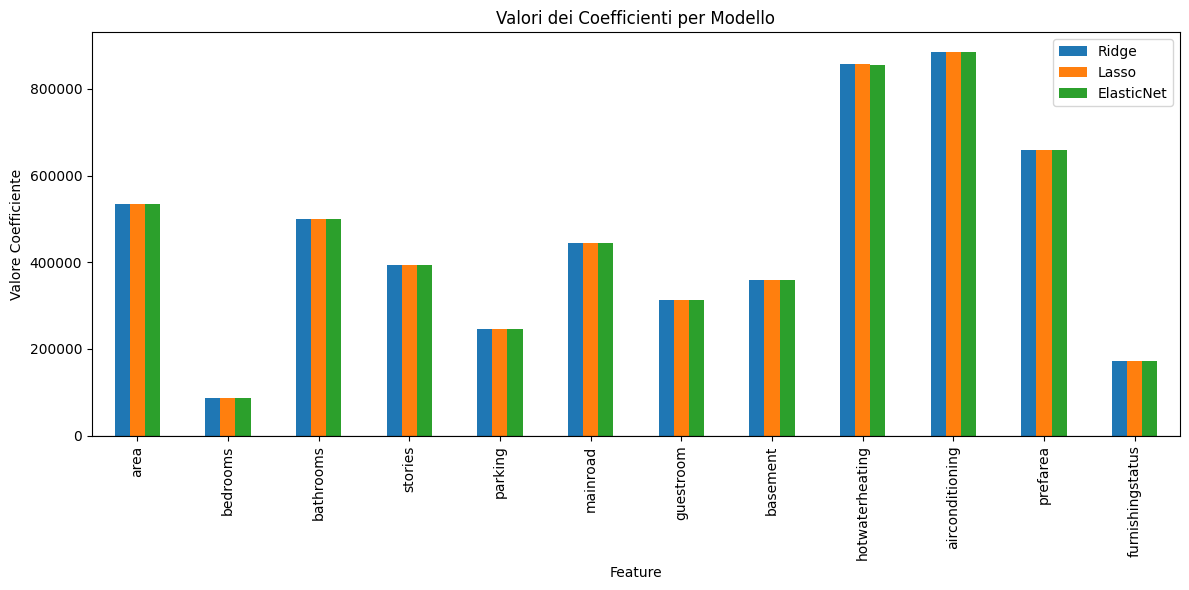

In [ ]:

# Analisi residui
plt.figure(figsize=(15, 6))
for i, (name, data) in enumerate(residuals.items()):
    plt.subplot(2, 3, i+1)
    sns.histplot(data['res'], kde=True, bins=30)
    plt.title(f"Distribuzione residui - {name}")

    plt.subplot(2, 3, i+4)
    plt.scatter(data['pred'], data['res'], alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residui vs Predetti - {name}")
    plt.xlabel("Valori predetti")
    plt.ylabel("Residui")
plt.tight_layout()
plt.show()


# Grafico coefficienti
coefs.set_index('Feature')[['Ridge', 'Lasso', 'ElasticNet']].plot(kind='bar', figsize=(12,6))
plt.title("Valori dei Coefficienti per Modello")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Valore Coefficiente")
plt.tight_layout()
plt.show()

# 📊 Analisi dei residui

I modelli catturano bene la tendenza generale, ma hanno difficoltà con le case più costose, introducendo errori crescenti su quella fascia di valori.